In [26]:
import numpy as np
import symforce

symforce.set_backend("sympy")
symforce.set_log_level("warning")
from symforce.notebook_util import display, print_expression_tree

from symforce import sympy as sm
from symforce import geo
from symforce import typing as T
from symforce.opt.factor import Factor
from symforce.opt.optimizer import Optimizer
from symforce.values import Values

from symforce.opt.barrier_functions import (
    min_max_power_barrier,
    min_max_linear_barrier,
    max_linear_barrier
)

import numpy as np
import matplotlib.pyplot as plt

v:
a_0*t + s_5*t**5 + s_6*t**6 + s_7*t**7 + s_8*t**8 + v_0 + t**2*(-280*T_A**9*s_8 - 189*T_A**8*s_7 - 108*T_A**7*s_6 - 42*T_A**6*s_5 - 378*T_A**2*a_0 + 126*T_A**2*a_A - 1512*T_A*v_0 - 1008*T_A*v_A + 2520*l_A)/(84*T_A**3) + t**3*(448*T_A**9*s_8 + 315*T_A**8*s_7 + 192*T_A**7*s_6 + 84*T_A**6*s_5 + 252*T_A**2*a_0 - 168*T_A**2*a_A + 1344*T_A*v_0 + 1176*T_A*v_A - 2520*l_A)/(42*T_A**4) + t**4*(-700*T_A**9*s_8 - 525*T_A**8*s_7 - 360*T_A**7*s_6 - 210*T_A**6*s_5 - 210*T_A**2*a_0 + 210*T_A**2*a_A - 1260*T_A*v_0 - 1260*T_A*v_A + 2520*l_A)/(84*T_A**5)
a:
a_0 + 5*s_5*t**4 + 6*s_6*t**5 + 7*s_7*t**6 + 8*s_8*t**7 + t*(-280*T_A**9*s_8 - 189*T_A**8*s_7 - 108*T_A**7*s_6 - 42*T_A**6*s_5 - 378*T_A**2*a_0 + 126*T_A**2*a_A - 1512*T_A*v_0 - 1008*T_A*v_A + 2520*l_A)/(42*T_A**3) + t**2*(448*T_A**9*s_8 + 315*T_A**8*s_7 + 192*T_A**7*s_6 + 84*T_A**6*s_5 + 252*T_A**2*a_0 - 168*T_A**2*a_A + 1344*T_A*v_0 + 1176*T_A*v_A - 2520*l_A)/(14*T_A**4) + t**3*(-700*T_A**9*s_8 - 525*T_A**8*s_7 - 360*T_A**7*s_6 - 210*T_A**6*s_5 -

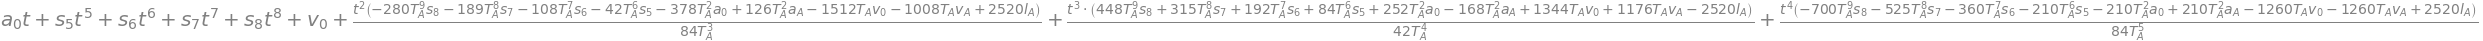

In [27]:
t = sm.Symbol("t")
T_a = sm.Symbol("T_A")
v_0 = sm.Symbol("v_0")
a_0 = sm.Symbol("a_0")
v_A = sm.Symbol("v_A")
a_A = sm.Symbol("a_A")
l_a = sm.Symbol("l_A")
pos = sm.Symbol("x")

polynomial_order = 8
coeffs = [sm.Symbol("s_{}".format(i)) for i in range(1, polynomial_order+1)]

def velocity_function(current_time):
    v_t = v_0
    for i in range(1, polynomial_order+1):
        v_t = v_t + coeffs[i-1] * current_time**i
    return v_t

def acc_function(current_time):
    tmp = sm.Symbol("tmp")
    return sm.diff(velocity_function(tmp), tmp).subs(tmp, current_time)

eq1 = sm.Eq(velocity_function(0), v_0)
eq2 = sm.Eq(velocity_function(T_a), v_A)
eq3 = sm.Eq(acc_function(0), a_0)
eq4 = sm.Eq(acc_function(T_a), a_A)
tmp = sm.Symbol("tmp")
eq5 = sm.Eq(sm.integrate(velocity_function(tmp), (tmp, 0, T_a)), l_a)

sol = sm.solve([eq1, eq2, eq3, eq4, eq5], coeffs[:4])

def sol_velocity_function_raw(current_time):
    return velocity_function(current_time).subs([(coeffs[0], sol[coeffs[0]]),
                                                 (coeffs[1], sol[coeffs[1]]),
                                                 (coeffs[2], sol[coeffs[2]]),
                                                 (coeffs[3], sol[coeffs[3]]),
                                                 ])

def sol_acc_function_raw(current_time):
    return sm.diff(sol_velocity_function_raw(t), t).subs(t, current_time)

def sol_jark_function_raw(current_time):
    return sm.diff(sol_acc_function_raw(t), t).subs(t, current_time)

def sol_pos_function_raw(current_time):
    return sm.integrate(sol_velocity_function_raw(t), (t, 0, t)).subs(t, current_time)

eq_l = sm.Eq(sol_pos_function_raw(t), pos)
pos_sol = sm.solve([eq_l], [t])

def sol_velocity_function(current_time, arrival_time, initial_v, initial_a, arrival_v, arrival_a, drive_length):
    return sol_velocity_function_raw(current_time).subs([
        (v_0, initial_v),
        (a_0, initial_a),
        (v_A, arrival_v),
        (a_A, arrival_a),
        (T_a, arrival_time),
        (l_a, drive_length)
    ])

print("v:")
print(sol_velocity_function_raw(t))

print("a:")
print(sm.diff(sol_velocity_function_raw(t), t))

sol_velocity_function_raw(t)

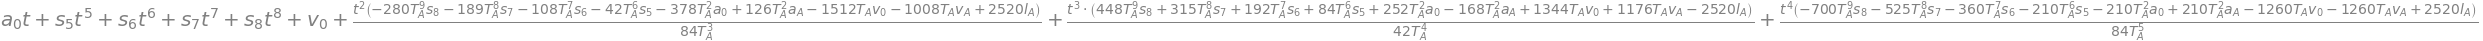

In [28]:
sol_velocity_function_raw(t)

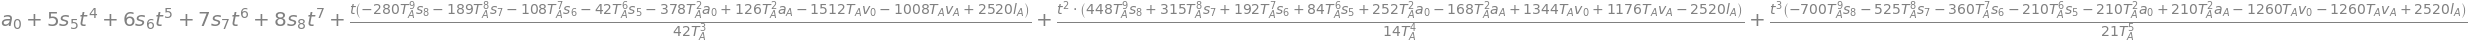

In [29]:
sol_acc_function_raw(t)

In [30]:
sol_pos_function_raw(t)
print(sol_pos_function_raw(t))

a_0*t**2/2 + s_5*t**6/6 + s_6*t**7/7 + s_7*t**8/8 + s_8*t**9/9 + t*v_0 + t**3*(-280*T_A**9*s_8 - 189*T_A**8*s_7 - 108*T_A**7*s_6 - 42*T_A**6*s_5 - 378*T_A**2*a_0 + 126*T_A**2*a_A - 1512*T_A*v_0 - 1008*T_A*v_A + 2520*l_A)/(252*T_A**3) + t**4*(448*T_A**9*s_8 + 315*T_A**8*s_7 + 192*T_A**7*s_6 + 84*T_A**6*s_5 + 252*T_A**2*a_0 - 168*T_A**2*a_A + 1344*T_A*v_0 + 1176*T_A*v_A - 2520*l_A)/(168*T_A**4) + t**5*(-140*T_A**9*s_8 - 105*T_A**8*s_7 - 72*T_A**7*s_6 - 42*T_A**6*s_5 - 42*T_A**2*a_0 + 42*T_A**2*a_A - 252*T_A*v_0 - 252*T_A*v_A + 504*l_A)/(84*T_A**5)


In [31]:
print(sol_jark_function_raw(t))

20*s_5*t**3 + 30*s_6*t**4 + 42*s_7*t**5 + 56*s_8*t**6 + (-280*T_A**9*s_8 - 189*T_A**8*s_7 - 108*T_A**7*s_6 - 42*T_A**6*s_5 - 378*T_A**2*a_0 + 126*T_A**2*a_A - 1512*T_A*v_0 - 1008*T_A*v_A + 2520*l_A)/(42*T_A**3) + t*(448*T_A**9*s_8 + 315*T_A**8*s_7 + 192*T_A**7*s_6 + 84*T_A**6*s_5 + 252*T_A**2*a_0 - 168*T_A**2*a_A + 1344*T_A*v_0 + 1176*T_A*v_A - 2520*l_A)/(7*T_A**4) + t**2*(-700*T_A**9*s_8 - 525*T_A**8*s_7 - 360*T_A**7*s_6 - 210*T_A**6*s_5 - 210*T_A**2*a_0 + 210*T_A**2*a_A - 1260*T_A*v_0 - 1260*T_A*v_A + 2520*l_A)/(7*T_A**5)


In [32]:
def velocity_function(t: T.Scalar,
                      v_0: T.Scalar,
                      a_0: T.Scalar,
                      v_A: T.Scalar,
                      a_A: T.Scalar,
                      T_A: T.Scalar,
                      l_A: T.Scalar,
                      s_5: T.Scalar,
                      s_6: T.Scalar,
                      s_7: T.Scalar,
                      s_8: T.Scalar) -> T.Scalar :
    return a_0*t + s_5*t**5 + s_6*t**6 + s_7*t**7 + s_8*t**8 + v_0 + t**2*(-280*T_A**9*s_8 - 189*T_A**8*s_7 - 108*T_A**7*s_6 - 42*T_A**6*s_5 - 378*T_A**2*a_0 + 126*T_A**2*a_A - 1512*T_A*v_0 - 1008*T_A*v_A + 2520*l_A)/(84*T_A**3) + t**3*(448*T_A**9*s_8 + 315*T_A**8*s_7 + 192*T_A**7*s_6 + 84*T_A**6*s_5 + 252*T_A**2*a_0 - 168*T_A**2*a_A + 1344*T_A*v_0 + 1176*T_A*v_A - 2520*l_A)/(42*T_A**4) + t**4*(-700*T_A**9*s_8 - 525*T_A**8*s_7 - 360*T_A**7*s_6 - 210*T_A**6*s_5 - 210*T_A**2*a_0 + 210*T_A**2*a_A - 1260*T_A*v_0 - 1260*T_A*v_A + 2520*l_A)/(84*T_A**5)

def acc_function(t: T.Scalar,
                      v_0: T.Scalar,
                      a_0: T.Scalar,
                      v_A: T.Scalar,
                      a_A: T.Scalar,
                      T_A: T.Scalar,
                      l_A: T.Scalar,
                      s_5: T.Scalar,
                      s_6: T.Scalar,
                      s_7: T.Scalar,
                      s_8: T.Scalar) -> T.Scalar :
    return a_0 + 5*s_5*t**4 + 6*s_6*t**5 + 7*s_7*t**6 + 8*s_8*t**7 + t*(-280*T_A**9*s_8 - 189*T_A**8*s_7 - 108*T_A**7*s_6 - 42*T_A**6*s_5 - 378*T_A**2*a_0 + 126*T_A**2*a_A - 1512*T_A*v_0 - 1008*T_A*v_A + 2520*l_A)/(42*T_A**3) + t**2*(448*T_A**9*s_8 + 315*T_A**8*s_7 + 192*T_A**7*s_6 + 84*T_A**6*s_5 + 252*T_A**2*a_0 - 168*T_A**2*a_A + 1344*T_A*v_0 + 1176*T_A*v_A - 2520*l_A)/(14*T_A**4) + t**3*(-700*T_A**9*s_8 - 525*T_A**8*s_7 - 360*T_A**7*s_6 - 210*T_A**6*s_5 - 210*T_A**2*a_0 + 210*T_A**2*a_A - 1260*T_A*v_0 - 1260*T_A*v_A + 2520*l_A)/(21*T_A**5)

def jerk_function(t: T.Scalar,
                 v_0: T.Scalar,
                 a_0: T.Scalar,
                 v_A: T.Scalar,
                 a_A: T.Scalar,
                 T_A: T.Scalar,
                 l_A: T.Scalar,
                 s_5: T.Scalar,
                 s_6: T.Scalar,
                 s_7: T.Scalar,
                 s_8: T.Scalar) -> T.Scalar :
    return 20*s_5*t**3 + 30*s_6*t**4 + 42*s_7*t**5 + 56*s_8*t**6 + (-280*T_A**9*s_8 - 189*T_A**8*s_7 - 108*T_A**7*s_6 - 42*T_A**6*s_5 - 378*T_A**2*a_0 + 126*T_A**2*a_A - 1512*T_A*v_0 - 1008*T_A*v_A + 2520*l_A)/(42*T_A**3) + t*(448*T_A**9*s_8 + 315*T_A**8*s_7 + 192*T_A**7*s_6 + 84*T_A**6*s_5 + 252*T_A**2*a_0 - 168*T_A**2*a_A + 1344*T_A*v_0 + 1176*T_A*v_A - 2520*l_A)/(7*T_A**4) + t**2*(-700*T_A**9*s_8 - 525*T_A**8*s_7 - 360*T_A**7*s_6 - 210*T_A**6*s_5 - 210*T_A**2*a_0 + 210*T_A**2*a_A - 1260*T_A*v_0 - 1260*T_A*v_A + 2520*l_A)/(7*T_A**5)


def pos_function(t: T.Scalar,
                 v_0: T.Scalar,
                 a_0: T.Scalar,
                 v_A: T.Scalar,
                 a_A: T.Scalar,
                 T_A: T.Scalar,
                 l_A: T.Scalar,
                 s_5: T.Scalar,
                 s_6: T.Scalar,
                 s_7: T.Scalar,
                 s_8: T.Scalar) -> T.Scalar :
    return a_0*t**2/2 + s_5*t**6/6 + s_6*t**7/7 + s_7*t**8/8 + s_8*t**9/9 + t*v_0 + t**3*(-280*T_A**9*s_8 - 189*T_A**8*s_7 - 108*T_A**7*s_6 - 42*T_A**6*s_5 - 378*T_A**2*a_0 + 126*T_A**2*a_A - 1512*T_A*v_0 - 1008*T_A*v_A + 2520*l_A)/(252*T_A**3) + t**4*(448*T_A**9*s_8 + 315*T_A**8*s_7 + 192*T_A**7*s_6 + 84*T_A**6*s_5 + 252*T_A**2*a_0 - 168*T_A**2*a_A + 1344*T_A*v_0 + 1176*T_A*v_A - 2520*l_A)/(168*T_A**4) + t**5*(-140*T_A**9*s_8 - 105*T_A**8*s_7 - 72*T_A**7*s_6 - 42*T_A**6*s_5 - 42*T_A**2*a_0 + 42*T_A**2*a_A - 252*T_A*v_0 - 252*T_A*v_A + 504*l_A)/(84*T_A**5)

In [33]:
def velocity_min_max_residual(t: T.Scalar,
                              v_0: T.Scalar,
                              a_0: T.Scalar,
                              v_A: T.Scalar,
                              a_A: T.Scalar,
                              T_A: T.Scalar,
                              l_A: T.Scalar,
                              s_5: T.Scalar,
                              s_6: T.Scalar,
                              s_7: T.Scalar,
                              s_8: T.Scalar) -> geo.V1 :
    return geo.V1(
        min_max_linear_barrier(velocity_function(t, v_0, a_0, v_A, a_A, T_A, l_A, s_5, s_6, s_7, s_8), 0, v_0, 100, 0.1)
    )

def acc_residual(t: T.Scalar,
                 v_0: T.Scalar,
                 a_0: T.Scalar,
                 v_A: T.Scalar,
                 a_A: T.Scalar,
                 T_A: T.Scalar,
                 l_A: T.Scalar,
                 s_5: T.Scalar,
                 s_6: T.Scalar,
                 s_7: T.Scalar,
                 s_8: T.Scalar) -> geo.V1 :
    return geo.V1(
        max_linear_barrier(acc_function(t, v_0, a_0, v_A, a_A, T_A, l_A, s_5, s_6, s_7, s_8), 0, 100, 0.1)
    )

def jerk_residual(t: T.Scalar,
                  v_0: T.Scalar,
                  a_0: T.Scalar,
                  v_A: T.Scalar,
                  a_A: T.Scalar,
                  T_A: T.Scalar,
                  l_A: T.Scalar,
                  s_5: T.Scalar,
                  s_6: T.Scalar,
                  s_7: T.Scalar,
                  s_8: T.Scalar,
                  min_jerk: T.Scalar,
                  max_jerk: T.Scalar) -> geo.V1 :
    return geo.V1(
        min_max_linear_barrier(jerk_function(t, v_0, a_0, v_A, a_A, T_A, l_A, s_5, s_6, s_7, s_8), min_jerk, max_jerk, 100, 0.01)
    )


In [34]:
factors = []

num_constraint = 20
for i in range(num_constraint):
    factors.append(
        Factor(
            # residual=velocity_min_max_residual,
            residual=acc_residual,
            keys=["times[{}]".format(i),
                  "v_0", "a_0",
                  "v_A", "a_A",
                  "T_A", "l_A", "s_5", "s_6", "s_7", "s_8"],
        )
    )

    factors.append(
        Factor(
            residual=velocity_min_max_residual,
            # residual=acc_residual,
            keys=["times[{}]".format(i),
                  "v_0", "a_0",
                  "v_A", "a_A",
                  "T_A", "l_A", "s_5", "s_6", "s_7", "s_8"],
        )
    )

    factors.append(
        Factor(
            residual=jerk_residual,
            # residual=acc_residual,
            keys=["times[{}]".format(i),
                  "v_0", "a_0",
                  "v_A", "a_A",
                  "T_A", "l_A", "s_5", "s_6", "s_7", "s_8", "min_jerk", "max_jerk"],
        )
    )

In [35]:
optimizer = Optimizer(
    factors=factors,
    optimized_keys=["s_5", "s_6", "s_7", "s_8"],
    debug_stats=True,
)

In [48]:
# initial_speed = 1.8
# initial_a = -0.05 * 9.8
# arrival_speed = 0
# arrival_a = -0.05 * 9.8
# drive_length = 20
# arrival_time = 30

# Melos: v_0: 0.8841837644577026, a_0: 0.0, v_A: 0.0, a_A: -0.07, L: 29.963892712230123, T_A: 40.382868384999995, MaxJ: 0.0, MinJ: -2.0

# initial_speed = 0.8
# initial_a = 0.0 # -0.05 * 9.8
# arrival_speed = 0
# arrival_a = -0.05 #-0.2 * 9.8
# drive_length = 5
# arrival_time = 13
# min_jerk = -2.0
# max_jerk = 0

#[motion_velocity_smoother-12] [INFO] [1656203872.895909372] [smoother.melos_smoother]: Melos: v_0: 0.8799999952316284, a_0: 0.0, v_A: 0.0, a_A: -0.38, L: 19.956257875510335, T_A: 25.035265088, MaxJ: 0.0, MinJ: -2.0

initial_speed = 0.8799999952316284
initial_a = 0.0 # -0.05 * 9.8
arrival_speed = 0
arrival_a = -0.38
drive_length = 19.956257875510335
arrival_time = 25.035265088
min_jerk = -2.0
max_jerk = 0

initial_values = Values(
    times = list(np.linspace(1, arrival_time-1, num_constraint)),
    v_0 = initial_speed,
    a_0 = initial_a,
    v_A = arrival_speed,
    a_A = arrival_a,
    T_A = arrival_time,
    l_A = drive_length,
    s_5 = 0,
    s_6 = 0,
    s_7 = 0,
    s_8 = 0,
    min_jerk = min_jerk,
    max_jerk = max_jerk
)

result = optimizer.optimize(initial_values)
print(result)

Optimizer.Result(initial_values=Values(
  times: [1.0, 2.2123823730526313, 3.424764746105263, 4.637147119157895, 5.849529492210526, 7.061911865263157, 8.27429423831579, 9.48667661136842, 10.699058984421052, 11.911441357473684, 13.123823730526315, 14.336206103578947, 15.54858847663158, 16.76097084968421, 17.97335322273684, 19.185735595789474, 20.398117968842104, 21.610500341894735, 22.82288271494737, 24.035265088],
  v_0: 0.8799999952316284,
  a_0: 0.0,
  v_A: 0,
  a_A: -0.38,
  T_A: 25.035265088,
  l_A: 19.956257875510335,
  s_5: 0,
  s_6: 0,
  s_7: 0,
  s_8: 0,
  min_jerk: -2.0,
  max_jerk: 0,
), optimized_values=Values(
  times: [1.0, 2.2123823730526313, 3.424764746105263, 4.637147119157895, 5.849529492210526, 7.061911865263157, 8.27429423831579, 9.48667661136842, 10.699058984421052, 11.911441357473684, 13.123823730526315, 14.336206103578947, 15.54858847663158, 16.76097084968421, 17.97335322273684, 19.185735595789474, 20.398117968842104, 21.610500341894735, 22.82288271494737, 24.0352

[1.0, 2.2123823730526313, 3.424764746105263, 4.637147119157895, 5.849529492210526, 7.061911865263157, 8.27429423831579, 9.48667661136842, 10.699058984421052, 11.911441357473684, 13.123823730526315, 14.336206103578947, 15.54858847663158, 16.76097084968421, 17.97335322273684, 19.185735595789474, 20.398117968842104, 21.610500341894735, 22.82288271494737, 24.035265088]


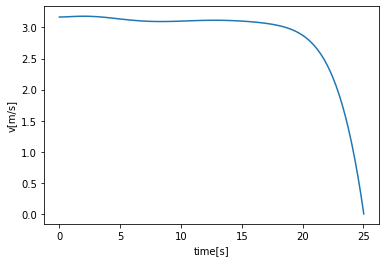

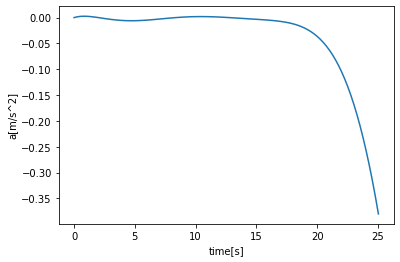

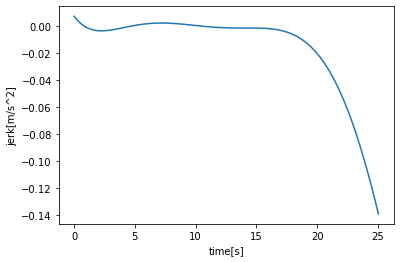

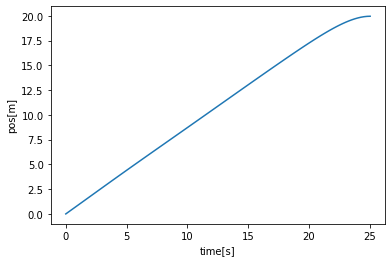

In [49]:
opt_s_5  = result.optimized_values["s_5"]
opt_s_6 = result.optimized_values["s_6"]
opt_s_7  = result.optimized_values["s_7"]
opt_s_8 = result.optimized_values["s_8"]

opt_t = np.linspace(0, arrival_time, 100)
opt_v = [3600/1000 * velocity_function(c_t, initial_speed, initial_a, arrival_speed, arrival_a, arrival_time, drive_length, opt_s_5, opt_s_6, opt_s_7, opt_s_8) for c_t in opt_t]
opt_acc = [acc_function(c_t, initial_speed, initial_a, arrival_speed, arrival_a, arrival_time, drive_length, opt_s_5, opt_s_6, opt_s_7, opt_s_8) for c_t in opt_t]
opt_jerk = [jerk_function(c_t, initial_speed, initial_a, arrival_speed, arrival_a, arrival_time, drive_length, opt_s_5, opt_s_6, opt_s_7, opt_s_8) for c_t in opt_t]
opt_pos = [pos_function(c_t, initial_speed, initial_a, arrival_speed, arrival_a, arrival_time, drive_length, opt_s_5, opt_s_6, opt_s_7, opt_s_8) for c_t in opt_t]

# plt.ylim([0, initial_speed])
plt.figure()
plt.plot(opt_t, opt_v)
plt.xlabel("time[s]")
plt.ylabel("v[m/s]")
plt.figure()
plt.plot(opt_t, opt_acc)
plt.xlabel("time[s]")
plt.ylabel("a[m/s^2]")
plt.figure()
plt.plot(opt_t, opt_jerk)
plt.xlabel("time[s]")
plt.ylabel("jerk[m/s^2]")
plt.figure()
plt.plot(opt_t, opt_pos)
plt.xlabel("time[s]")
plt.ylabel("pos[m]")

print(list(np.linspace(1, arrival_time-1, num_constraint)))

In [38]:
from symforce.codegen import Codegen, CppConfig

codegen_velocity = Codegen.function(velocity_min_max_residual, config=CppConfig())
codegen_velocity_linearization = codegen_velocity.with_linearization(
    which_args=["s_5", "s_6", "s_7", "s_8"]
)
metadata = codegen_velocity_linearization.generate_function("/home/autoware/tmp")
print(open(metadata.generated_files[0]).read())

// -----------------------------------------------------------------------------
// This file was autogenerated by symforce from template:
//     cpp_templates/function/FUNCTION.h.jinja
// Do NOT modify by hand.
// -----------------------------------------------------------------------------

#pragma once

#include <Eigen/Dense>

namespace sym {

/**
 * This function was autogenerated from a symbolic function. Do not modify by hand.
 *
 * Symbolic function: velocity_min_max_residual
 *
 * Args:
 *     t: Scalar
 *     v_0: Scalar
 *     a_0: Scalar
 *     v_A: Scalar
 *     a_A: Scalar
 *     T_A: Scalar
 *     l_A: Scalar
 *     s_5: Scalar
 *     s_6: Scalar
 *     s_7: Scalar
 *     s_8: Scalar
 *
 * Outputs:
 *     res: Matrix11
 *     jacobian: (1x4) jacobian of res wrt args s_5 (1), s_6 (1), s_7 (1), s_8 (1)
 *     hessian: (4x4) Gauss-Newton hessian for args s_5 (1), s_6 (1), s_7 (1), s_8 (1)
 *     rhs: (4x1) Gauss-Newton rhs for args s_5 (1), s_6 (1), s_7 (1), s_8 (1)
 */
temp

In [39]:
codegen_acc = Codegen.function(acc_residual, config=CppConfig())
codegen_acc_linearization = codegen_acc.with_linearization(
    which_args=["s_5", "s_6", "s_7", "s_8"]
)
metadata_acc = codegen_acc_linearization.generate_function("/home/autoware/tmp")
print(open(metadata_acc.generated_files[0]).read())

// -----------------------------------------------------------------------------
// This file was autogenerated by symforce from template:
//     cpp_templates/function/FUNCTION.h.jinja
// Do NOT modify by hand.
// -----------------------------------------------------------------------------

#pragma once

#include <Eigen/Dense>

namespace sym {

/**
 * This function was autogenerated from a symbolic function. Do not modify by hand.
 *
 * Symbolic function: acc_residual
 *
 * Args:
 *     t: Scalar
 *     v_0: Scalar
 *     a_0: Scalar
 *     v_A: Scalar
 *     a_A: Scalar
 *     T_A: Scalar
 *     l_A: Scalar
 *     s_5: Scalar
 *     s_6: Scalar
 *     s_7: Scalar
 *     s_8: Scalar
 *
 * Outputs:
 *     res: Matrix11
 *     jacobian: (1x4) jacobian of res wrt args s_5 (1), s_6 (1), s_7 (1), s_8 (1)
 *     hessian: (4x4) Gauss-Newton hessian for args s_5 (1), s_6 (1), s_7 (1), s_8 (1)
 *     rhs: (4x1) Gauss-Newton rhs for args s_5 (1), s_6 (1), s_7 (1), s_8 (1)
 */
template <typenam

In [40]:
codegen_jerk = Codegen.function(jerk_residual, config=CppConfig())
codegen_jerk_linearization = codegen_jerk.with_linearization(
    which_args=["s_5", "s_6", "s_7", "s_8"]
)
metadata_jerk = codegen_jerk_linearization.generate_function("/home/autoware/tmp")
print(open(metadata_jerk.generated_files[0]).read())

// -----------------------------------------------------------------------------
// This file was autogenerated by symforce from template:
//     cpp_templates/function/FUNCTION.h.jinja
// Do NOT modify by hand.
// -----------------------------------------------------------------------------

#pragma once

#include <Eigen/Dense>

namespace sym {

/**
 * This function was autogenerated from a symbolic function. Do not modify by hand.
 *
 * Symbolic function: jerk_residual
 *
 * Args:
 *     t: Scalar
 *     v_0: Scalar
 *     a_0: Scalar
 *     v_A: Scalar
 *     a_A: Scalar
 *     T_A: Scalar
 *     l_A: Scalar
 *     s_5: Scalar
 *     s_6: Scalar
 *     s_7: Scalar
 *     s_8: Scalar
 *     min_jerk: Scalar
 *     max_jerk: Scalar
 *
 * Outputs:
 *     res: Matrix11
 *     jacobian: (1x4) jacobian of res wrt args s_5 (1), s_6 (1), s_7 (1), s_8 (1)
 *     hessian: (4x4) Gauss-Newton hessian for args s_5 (1), s_6 (1), s_7 (1), s_8 (1)
 *     rhs: (4x1) Gauss-Newton rhs for args s_5 (1)

In [41]:
codegen_vf = Codegen.function(velocity_function, config=CppConfig())
metadata_vf = codegen_vf.generate_function("/home/autoware/tmp")
print(open(metadata_vf.generated_files[0]).read())

// -----------------------------------------------------------------------------
// This file was autogenerated by symforce from template:
//     cpp_templates/function/FUNCTION.h.jinja
// Do NOT modify by hand.
// -----------------------------------------------------------------------------

#pragma once

#include <Eigen/Dense>

namespace sym {

/**
 * This function was autogenerated from a symbolic function. Do not modify by hand.
 *
 * Symbolic function: velocity_function
 *
 * Args:
 *     t: Scalar
 *     v_0: Scalar
 *     a_0: Scalar
 *     v_A: Scalar
 *     a_A: Scalar
 *     T_A: Scalar
 *     l_A: Scalar
 *     s_5: Scalar
 *     s_6: Scalar
 *     s_7: Scalar
 *     s_8: Scalar
 *
 * Outputs:
 *     res: Scalar
 */
template <typename Scalar>
Scalar VelocityFunction(const Scalar t, const Scalar v_0, const Scalar a_0, const Scalar v_A,
                        const Scalar a_A, const Scalar T_A, const Scalar l_A, const Scalar s_5,
                        const Scalar s_6, cons

In [42]:
codegen_af = Codegen.function(acc_function, config=CppConfig())
metadata_af = codegen_af.generate_function("/home/autoware/tmp")
print(open(metadata_af.generated_files[0]).read())

// -----------------------------------------------------------------------------
// This file was autogenerated by symforce from template:
//     cpp_templates/function/FUNCTION.h.jinja
// Do NOT modify by hand.
// -----------------------------------------------------------------------------

#pragma once

#include <Eigen/Dense>

namespace sym {

/**
 * This function was autogenerated from a symbolic function. Do not modify by hand.
 *
 * Symbolic function: acc_function
 *
 * Args:
 *     t: Scalar
 *     v_0: Scalar
 *     a_0: Scalar
 *     v_A: Scalar
 *     a_A: Scalar
 *     T_A: Scalar
 *     l_A: Scalar
 *     s_5: Scalar
 *     s_6: Scalar
 *     s_7: Scalar
 *     s_8: Scalar
 *
 * Outputs:
 *     res: Scalar
 */
template <typename Scalar>
Scalar AccFunction(const Scalar t, const Scalar v_0, const Scalar a_0, const Scalar v_A,
                   const Scalar a_A, const Scalar T_A, const Scalar l_A, const Scalar s_5,
                   const Scalar s_6, const Scalar s_7, const 

In [43]:
codegen_jf = Codegen.function(jerk_function, config=CppConfig())
metadata_jf = codegen_jf.generate_function("/home/autoware/tmp")
print(open(metadata_jf.generated_files[0]).read())

// -----------------------------------------------------------------------------
// This file was autogenerated by symforce from template:
//     cpp_templates/function/FUNCTION.h.jinja
// Do NOT modify by hand.
// -----------------------------------------------------------------------------

#pragma once

#include <Eigen/Dense>

namespace sym {

/**
 * This function was autogenerated from a symbolic function. Do not modify by hand.
 *
 * Symbolic function: jerk_function
 *
 * Args:
 *     t: Scalar
 *     v_0: Scalar
 *     a_0: Scalar
 *     v_A: Scalar
 *     a_A: Scalar
 *     T_A: Scalar
 *     l_A: Scalar
 *     s_5: Scalar
 *     s_6: Scalar
 *     s_7: Scalar
 *     s_8: Scalar
 *
 * Outputs:
 *     res: Scalar
 */
template <typename Scalar>
Scalar JerkFunction(const Scalar t, const Scalar v_0, const Scalar a_0, const Scalar v_A,
                    const Scalar a_A, const Scalar T_A, const Scalar l_A, const Scalar s_5,
                    const Scalar s_6, const Scalar s_7, co

In [44]:
codegen_pf = Codegen.function(pos_function, config=CppConfig())
metadata_pf = codegen_pf.generate_function("/home/autoware/tmp")
print(open(metadata_pf.generated_files[0]).read())

// -----------------------------------------------------------------------------
// This file was autogenerated by symforce from template:
//     cpp_templates/function/FUNCTION.h.jinja
// Do NOT modify by hand.
// -----------------------------------------------------------------------------

#pragma once

#include <Eigen/Dense>

namespace sym {

/**
 * This function was autogenerated from a symbolic function. Do not modify by hand.
 *
 * Symbolic function: pos_function
 *
 * Args:
 *     t: Scalar
 *     v_0: Scalar
 *     a_0: Scalar
 *     v_A: Scalar
 *     a_A: Scalar
 *     T_A: Scalar
 *     l_A: Scalar
 *     s_5: Scalar
 *     s_6: Scalar
 *     s_7: Scalar
 *     s_8: Scalar
 *
 * Outputs:
 *     res: Scalar
 */
template <typename Scalar>
Scalar PosFunction(const Scalar t, const Scalar v_0, const Scalar a_0, const Scalar v_A,
                   const Scalar a_A, const Scalar T_A, const Scalar l_A, const Scalar s_5,
                   const Scalar s_6, const Scalar s_7, const 

In [45]:
(1.3/3.6)/4